In [2]:
# !pip install openmeteo-requests
# !python -m pip install scikit-learn

In [3]:
# This import doesn't even work on colab for some reason. Weird.
# import openmeteo_requests

# import requests_cache
# import pandas as pd
# from retry_requests import retry

# # Setup the Open-Meteo API client with cache and retry on error
# cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
# retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
# openmeteo = openmeteo_requests.Client(session = retry_session)

# # Make sure all required weather variables are listed here
# # The order of variables in hourly or daily is important to assign them correctly below
# url = "https://archive-api.open-meteo.com/v1/archive"
# params = {
# 	"latitude": [40.79736, 41.78701, 30.1444, 25.7738],
# 	"longitude": [-73.97785, -87.77166, -97.66876, -80.1936],
# 	"start_date": "2024-03-01",
# 	"end_date": "2023-03-01",
# 	"hourly": "temperature_2m"
# }
# responses = openmeteo.weather_api(url, params=params)

# # Process first location. Add a for-loop for multiple locations or weather models
# response = responses[0]
# print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
# print(f"Elevation {response.Elevation()} m asl")
# print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
# print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# # Process hourly data. The order of variables needs to be the same as requested.
# hourly = response.Hourly()
# hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()

# hourly_data = {"date": pd.date_range(
# 	start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
# 	end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
# 	freq = pd.Timedelta(seconds = hourly.Interval()),
# 	inclusive = "left"
# )}
# hourly_data["temperature_2m"] = hourly_temperature_2m

# hourly_dataframe = pd.DataFrame(data = hourly_data)
# print(hourly_dataframe)


In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/Users/pranav/miniconda3/bin/python
3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:38:07) [Clang 16.0.6 ]
sys.version_info(major=3, minor=11, micro=7, releaselevel='final', serial=0)


In [34]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [6]:
# API call using requests

import requests

latitudes = '25.7738,30.1444,41.78701,40.79736'
longitudes = '-80.1936,-97.66876,-87.77166,-73.97785'
start_date = '2016-01-01'
end_date = '2024-03-01'

# TODO: update this API call to include more features
# sunshine_duration, 
required_metrics = "temperature_2m_max,sunshine_duration,precipitation_probability_max"
url = "https://api.open-meteo.com/v1/forecast?latitude="+ latitudes + "&longitude=" + longitudes+ "&daily=" + required_metrics + "&start_date="+ start_date + "&end_date=" + end_date

payload={}
headers = {}

response = requests.request("GET", url, headers=headers, data=payload)

# print(response.text)



In [7]:
data = response.json()

# 25.77380,-80.19360 - Miama, FL
# 30.14440,-97.66876 - Texas
# 41.78701,-87.77166 - Chicago, IL
# 40.79736,-73.97785 - New York

# Create individual vars for temps for each place
temps_fl = data[0]
temps_tx = data[1]
temps_il = data[2]
temps_ny = data[3]

In [28]:
# create dataframes out of the dict
def clean_temp_data(temps_data):
    clean_fl = {
        'time': [],
        'temperature_2m_max': [],
        'sunshine_duration':[],
        'precipitation_probability_max':[]
    }
    for i in range(len(temps_data['daily']['time'])):
        # print(temps_data['daily']['temperature_2m_max'][i])
        if temps_data['daily']['temperature_2m_max'][i] is not None :
            clean_fl['time'].append(temps_data['daily']['time'][i])
            clean_fl['temperature_2m_max'].append(temps_data['daily']['temperature_2m_max'][i])
            clean_fl['sunshine_duration'].append(temps_data['daily']['sunshine_duration'][i])
            clean_fl['precipitation_probability_max'].append(temps_data['daily']['precipitation_probability_max'][i])
            # print(temps_data['daily']['precipitation_probability_max'][i])
            # print(temps_data['daily']['time'][i], temps_data['daily']['temperature_2m_max'][i])

    # print(clean_fl)
    
    # Convert the dictionary to a DataFrame
    clean_df = pd.DataFrame(clean_fl)
    clean_df['sunshine_duration'].fillna(clean_df['sunshine_duration'].mean())
    clean_df = clean_df.interpolate()
    # print(clean_df)
    return clean_df

In [29]:
df_fl = clean_temp_data(temps_fl)
df_il = clean_temp_data(temps_il)
df_tx = clean_temp_data(temps_tx)
df_ny = clean_temp_data(temps_ny)

print(df_fl)
# print(df_il)
# print(df_tx)
# print(df_ny)

           time  temperature_2m_max  sunshine_duration  \
0    2023-09-21                30.5           41110.61   
1    2023-09-22                29.8           38020.24   
2    2023-09-23                28.8           40928.12   
3    2023-09-24                30.0           40744.77   
4    2023-09-25                31.0           40016.88   
..          ...                 ...                ...   
158  2024-02-26                24.0           35295.91   
159  2024-02-27                24.9           38988.08   
160  2024-02-28                25.8           37944.30   
161  2024-02-29                26.0           24794.83   
162  2024-03-01                24.8           35646.97   

     precipitation_probability_max  
0                              NaN  
1                              NaN  
2                              NaN  
3                              NaN  
4                              NaN  
..                             ...  
158                            0.0  
159    

/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_14378/2309240598.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  clean_df = clean_df.interpolate()
/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_14378/2309240598.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  clean_df = clean_df.interpolate()
/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_14378/2309240598.py:24: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  clean_df = clean_df.interpolate()
/var/folders/b9/fkf035lj1y786gv5xh300_qc0000gn/T/ipykernel_14378/2309240598.py:24: FutureWarning: DataFrame.interpolate with object d

In [30]:
# some time related cleanup

df = df_fl
df['time'] = pd.to_datetime(df['time'])

# Calculate the number of days since the first date in the dataset
min_date = df['time'].min()
df['time_delta'] = (df['time'] - min_date).dt.days


Test MSE: 2.9424044871474737


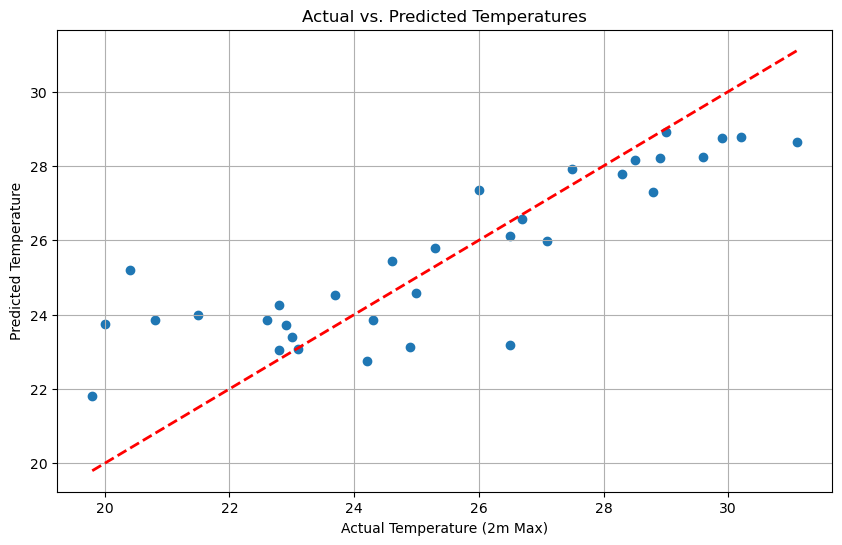

/Users/pranav/miniconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: X has 1 features, but LinearRegression is expecting 2 features as input.

In [38]:
# Define features and target variable
X = df[['time_delta', 'sunshine_duration']]  # Our features
y = df['temperature_2m_max']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
predictions = model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, predictions)
print(f"Test MSE: {mse}")


# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.scatter(y_test, predictions, alpha=1)  # Plot the predictions vs the actual values

# Plot a line representing the perfect predictions
# This means every actual value is equal to the predicted value
min_val = min(y_test.min(), predictions.min())
max_val = max(y_test.max(), predictions.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2)

plt.title('Actual vs. Predicted Temperatures')
plt.xlabel('Actual Temperature (2m Max)')
plt.ylabel('Predicted Temperature')
plt.grid(True)
plt.show()

# To predict the temperature for a specific future date
predict_date = pd.to_datetime('2024-03-02')  # Example date
predict_date_delta = (predict_date - min_date).days # Convert to numerical format
predict_sunlight_duration = 34275
predict_precipitation_max = 45

# Use the model to predict
predict_temp = model.predict([[predict_date_delta]])
print(f"Predicted temperature for {predict_date.date()}: {predict_temp[0]}°")
